# 4장. 그레이디언트 부스팅에서 XGBoost까지

*아래 링크를 통해 이 노트북을 주피터 노트북 뷰어(nbviewer.org)로 보거나 구글 코랩(colab.research.google.com)에서 실행할 수 있습니다.*

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://nbviewer.org/github/rickiepark/handson-gb/blob/main/Chapter04/Gradient_Boosting.ipynb"><img src="https://jupyter.org/assets/share.png" width="60" />주피터 노트북 뷰어로 보기</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/rickiepark/handson-gb/blob/main/Chapter04/Gradient_Boosting.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />구글 코랩(Colab)에서 실행하기</a>
  </td>
</table>

In [1]:
# 노트북이 코랩에서 실행 중인지 체크합니다.
import sys
if 'google.colab' in sys.modules:
    !pip install -q --upgrade xgboost
    !wget -q https://raw.githubusercontent.com/rickiepark/handson-gb/main/Chapter04/bike_rentals_cleaned.csv
    !wget -q https://raw.githubusercontent.com/rickiepark/handson-gb/main/Chapter04/exoplanets.csv.zip
    !unzip exoplanets.csv.zip

## 그레이디언트 부스팅 작동 방식

### 그레이디언트 부스팅 모델 구축 방법 배우기

#### 자전거 대여 데이터셋 로드하기

In [2]:
# pandas와 numpy 임포트하기
import pandas as pd
import numpy as np

# 경고 끄기
import warnings
warnings.filterwarnings('ignore')

import xgboost as xgb
xgb.set_config(verbosity=0)

In [3]:
df_bikes = pd.read_csv('bike_rentals_cleaned.csv')
df_bikes.head()

,instant,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,cnt
0,1,1.0,0.0,1.0,0.0,6.0,0.0,2,0.344167,0.363625,0.805833,0.160446,985
1,2,1.0,0.0,1.0,0.0,0.0,0.0,2,0.363478,0.353739,0.696087,0.248539,801
2,3,1.0,0.0,1.0,0.0,1.0,1.0,1,0.196364,0.189405,0.437273,0.248309,1349
3,4,1.0,0.0,1.0,0.0,2.0,1.0,1,0.200000,0.212122,0.590435,0.160296,1562
4,5,1.0,0.0,1.0,0.0,3.0,1.0,1,0.226957,0.229270,0.436957,0.186900,1600


In [4]:
# 데이터를 X와 y로 나눕니다.
X_bikes = df_bikes.iloc[:,:-1]
y_bikes = df_bikes.iloc[:,-1]

# train_test_split를 임포트합니다.
from sklearn.model_selection import train_test_split

# 데이터를 훈련 세트와 테스트 세트로 나눕니다.
X_train, X_test, y_train, y_test = train_test_split(X_bikes, y_bikes, random_state=2)

#### 그레이디언트 부스팅 모델 만들기

In [5]:
# DecisionTreeRegressor를 임포트합니다.
from sklearn.tree import DecisionTreeRegressor

# DecisionTreeRegressor를 초기화합니다.
tree_1 = DecisionTreeRegressor(max_depth=2, random_state=2)

# 훈련 세트에 결정 트리를 훈련합니다.
tree_1.fit(X_train, y_train)

DecisionTreeRegressor(max_depth=2, random_state=2)

In [6]:
# 훈련 세트에 대한 예측을 만듭니다.
y_train_pred = tree_1.predict(X_train)

In [7]:
# 잔차를 계산합니다.
y2_train = y_train - y_train_pred

# DecisionTreeRegressor를 초기화합니다.
tree_2 = DecisionTreeRegressor(max_depth=2, random_state=2)

# 잔차에 모델을 훈련합니다.
tree_2.fit(X_train, y2_train)

DecisionTreeRegressor(max_depth=2, random_state=2)

In [8]:
# 훈련 세트에 대한 예측을 만듭니다.
y2_train_pred = tree_2.predict(X_train)

# 잔차를 계산합니다.
y3_train = y2_train - y2_train_pred

# DecisionTreeRegressor를 초기화합니다.
tree_3 = DecisionTreeRegressor(max_depth=2, random_state=2)

# 잔차에 모델을 훈련합니다.
tree_3.fit(X_train, y3_train)

DecisionTreeRegressor(max_depth=2, random_state=2)

In [9]:
y1_pred = tree_1.predict(X_test)

y2_pred = tree_2.predict(X_test)

y3_pred = tree_3.predict(X_test)

y_pred = y1_pred + y2_pred + y3_pred

# mean_squared_error를 임포트합니다.
from sklearn.metrics import mean_squared_error as MSE

# 평균 제곱근 오차를 계산합니다.
MSE(y_test, y_pred)**0.5

911.0479538776444

#### 사이킷런 구현

In [10]:
res_1 = y_train - np.mean(y_train)

In [11]:
tree_1.fit(X_train, res_1)
pred_1 = tree_1.predict(X_train)
res_2 = y_train - pred_1

In [12]:
tree_2.fit(X_train, res_2)
pred_2 = tree_2.predict(X_train)
res_3 = y_train - (pred_1 + pred_2)

In [13]:
tree_3.fit(X_train, res_3)

DecisionTreeRegressor(max_depth=2, random_state=2)

In [14]:
from sklearn.metrics import mean_squared_error

pred_all = tree_1.predict(X_test) + tree_2.predict(X_test) + tree_3.predict(X_test)
mean_squared_error(y_test, pred_all, squared=False)

911.0479538776432

### 사이킷런으로 그레이디언트 부스팅 모델 만들기

In [15]:
from sklearn.ensemble import GradientBoostingRegressor

In [16]:
gbr = GradientBoostingRegressor(max_depth=2, n_estimators=3, 
                                random_state=2, learning_rate=1.0)

gbr.fit(X_train, y_train)

# 테스트 데이터에 대한 예측을 만듭니다.
y_pred = gbr.predict(X_test)

# 평균 제곱근 오차를 계산합니다.
MSE(y_test, y_pred)**0.5

911.0479538776439

In [17]:
gbr = GradientBoostingRegressor(max_depth=2, n_estimators=30, 
                                random_state=2, learning_rate=1.0)
gbr.fit(X_train, y_train)
y_pred = gbr.predict(X_test)
MSE(y_test, y_pred)**0.5

857.1072323426944

In [18]:
gbr = GradientBoostingRegressor(max_depth=2, n_estimators=300, 
                                random_state=2, learning_rate=1.0)
gbr.fit(X_train, y_train)
y_pred = gbr.predict(X_test)
MSE(y_test, y_pred)**0.5

936.3617413678853

In [19]:
gbr = GradientBoostingRegressor(max_depth=2, n_estimators=300, random_state=2)
gbr.fit(X_train, y_train)
y_pred = gbr.predict(X_test)
MSE(y_test, y_pred)**0.5

653.7456840231495

## 그레이디언트 부스팅 매개변수 튜닝

### learning_rate

In [20]:
learning_rate_values = [0.001, 0.01, 0.05, 0.1, 0.15, 0.2, 0.3, 0.5, 1.0]
for value in learning_rate_values:
    gbr = GradientBoostingRegressor(max_depth=2, n_estimators=300, 
                                    random_state=2, learning_rate=value)
    gbr.fit(X_train, y_train)
    y_pred = gbr.predict(X_test)
    rmse = MSE(y_test, y_pred)**0.5
    print('학습률:', value, ', 점수:', rmse)

학습률: 0.001 , 점수: 1633.0261400367258
학습률: 0.01 , 점수: 831.5430182728547
학습률: 0.05 , 점수: 685.0192988749717
학습률: 0.1 , 점수: 653.7456840231495
학습률: 0.15 , 점수: 687.666134269379
학습률: 0.2 , 점수: 664.312804425697
학습률: 0.3 , 점수: 689.4190385930236
학습률: 0.5 , 점수: 693.8856905068778
학습률: 1.0 , 점수: 936.3617413678853


In [21]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set()

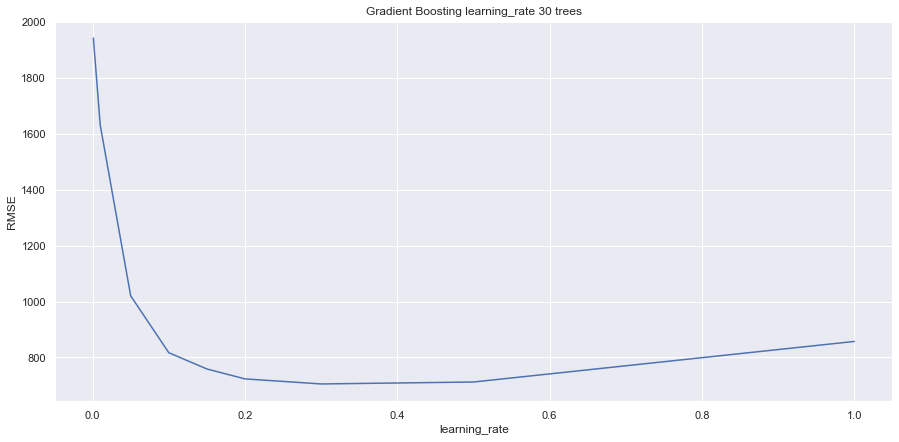

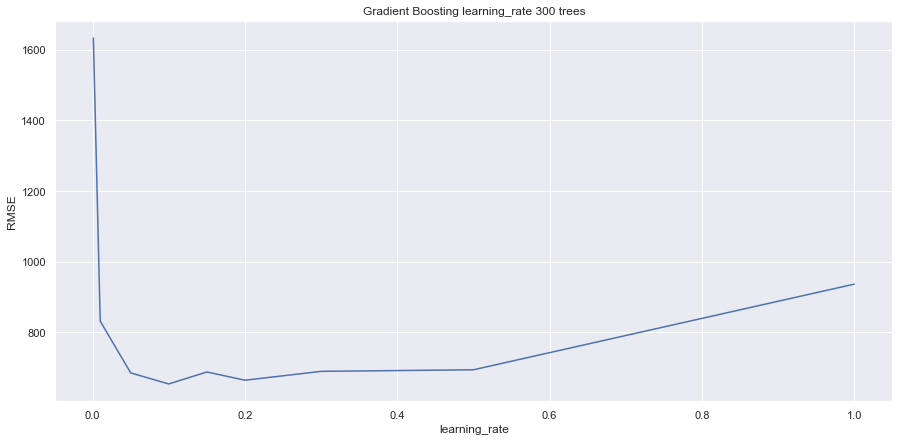

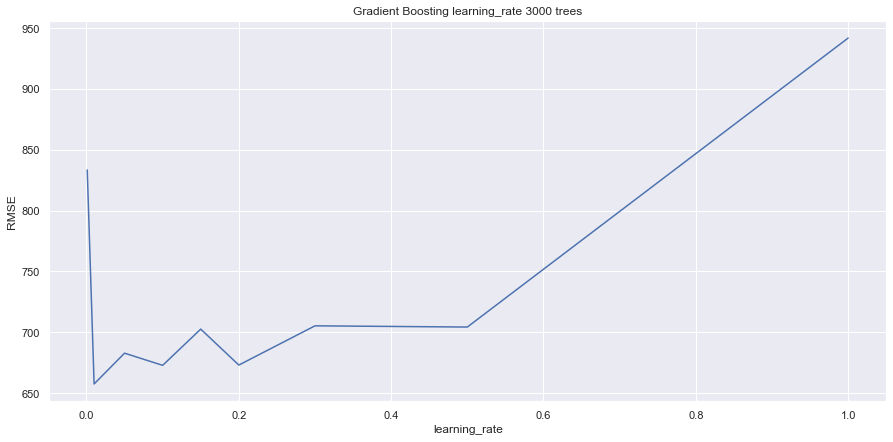

In [22]:
from sklearn.metrics import mean_squared_error

for est in [30, 300, 3000]:
    rmse_scores = []
    for value in learning_rate_values:
        gbr = GradientBoostingRegressor(max_depth=2, n_estimators=est, 
                                        random_state=2, learning_rate=value)
        gbr.fit(X_train, y_train)
        y_pred = gbr.predict(X_test)
        rmse = mean_squared_error(y_test, y_pred, squared=False)
        rmse_scores.append(rmse)
    plt.figure(figsize=(15,7))
    plt.plot(learning_rate_values, rmse_scores)
    plt.xlabel('learning_rate')
    plt.ylabel('RMSE')
    plt.title('Gradient Boosting learning_rate {} trees'.format(est))
    plt.savefig('Gradient Boosting learning_rate {} trees'.format(est), dpi=325)
    plt.show()

### 기본 학습기

In [23]:
depths = [None, 1, 2, 3, 4]
for depth in depths:
    gbr = GradientBoostingRegressor(max_depth=depth, n_estimators=300, 
                                    random_state=2)
    gbr.fit(X_train, y_train)
    y_pred = gbr.predict(X_test)
    rmse = MSE(y_test, y_pred)**0.5
    print('최대 깊이:', depth, ', 점수:', rmse)

최대 깊이: None , 점수: 869.2788645118395
최대 깊이: 1 , 점수: 707.8261886858736
최대 깊이: 2 , 점수: 653.7456840231495
최대 깊이: 3 , 점수: 646.4045923317708
최대 깊이: 4 , 점수: 663.048387855927


In [24]:
gbr.init_

DummyRegressor()

In [25]:
len(gbr.estimators_)

300

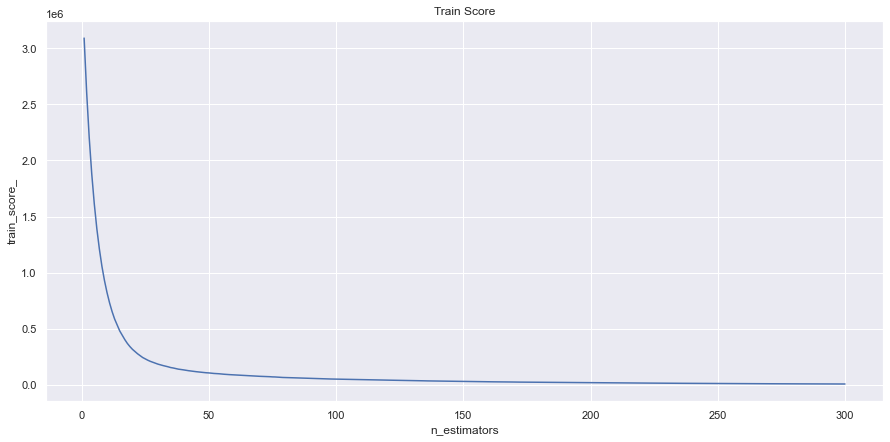

In [26]:
plt.figure(figsize=(15,7))
plt.plot(range(1, 301), gbr.train_score_)
plt.xlabel('n_estimators')
plt.ylabel('train_score_')
plt.title('Train Score')
plt.savefig('train_score', dpi=325)
plt.show()

### subsample

In [27]:
samples = [1, 0.9, 0.8, 0.7, 0.6, 0.5]
for sample in samples:
    gbr = GradientBoostingRegressor(max_depth=3, n_estimators=300, 
                                    subsample=sample, random_state=2)
    gbr.fit(X_train, y_train)
    y_pred = gbr.predict(X_test)
    rmse = MSE(y_test, y_pred)**0.5
    print('subsample:', sample, ', 점수:', rmse)

subsample: 1 , 점수: 646.4045923317708
subsample: 0.9 , 점수: 620.1819001443569
subsample: 0.8 , 점수: 617.2355650565677
subsample: 0.7 , 점수: 612.9879156983139
subsample: 0.6 , 점수: 622.6385116402317
subsample: 0.5 , 점수: 626.9974073227554


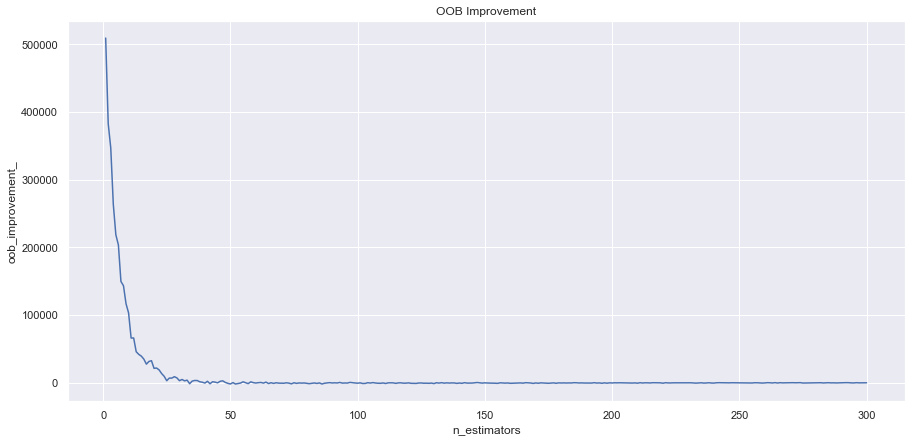

In [28]:
plt.figure(figsize=(15,7))
plt.plot(range(1, 301), gbr.oob_improvement_)
plt.xlabel('n_estimators')
plt.ylabel('oob_improvement_')
plt.title('OOB Improvement')
plt.savefig('oob_improvement', dpi=325)
plt.show()

### RandomizedSearchCV

In [29]:
params = {'subsample':[0.65, 0.7, 0.75],
          'n_estimators':[300, 500, 1000],
          'learning_rate':[0.05, 0.075, 0.1]}

# RandomizedSearchCV를 임포트합니다.
from sklearn.model_selection import RandomizedSearchCV

gbr = GradientBoostingRegressor(max_depth=3, random_state=2)


# RandomizedSearchCV를 초기화합니다.
rand_reg = RandomizedSearchCV(gbr, params, n_iter=10, 
                              scoring='neg_mean_squared_error', 
                              cv=5, n_jobs=-1, random_state=2)

# X_train와 y_train로 rand_reg를 훈련합니다.
rand_reg.fit(X_train, y_train)

# 최상의 모델을 추출합니다.
best_model = rand_reg.best_estimator_

# 최상의 매개변수를 추출합니다.
best_params = rand_reg.best_params_

# 최상의 매개변수를 출력합니다.
print("최상의 매개변수:", best_params)

# 최상의 점수를 계산합니다.
best_score = np.sqrt(-rand_reg.best_score_)

# 최상의 점수를 출력합니다.
print("훈련 점수: {:.3f}".format(best_score))

# 테스트 세트에 대한 예측을 만듭니다.
y_pred = best_model.predict(X_test)

# 평균 제곱근 오차를 계산합니다.
rmse_test = MSE(y_test, y_pred)**0.5

# 평균 제곱근 오차를 출력합니다.
print('테스트 세트 점수: {:.3f}'.format(rmse_test))

최상의 매개변수: {'subsample': 0.65, 'n_estimators': 300, 'learning_rate': 0.05}
훈련 점수: 636.200
테스트 세트 점수: 625.985


In [30]:
gbr = GradientBoostingRegressor(max_depth=3, n_estimators=1600, 
                                subsample=0.75, learning_rate=0.02, 
                                random_state=2)
gbr.fit(X_train, y_train)
y_pred = gbr.predict(X_test)
MSE(y_test, y_pred)**0.5

596.9544588974487

### XGBoost

In [31]:
# XGBRegressor를 임포트합니다.
from xgboost import XGBRegressor

# XGBRegressor를 초기화합니다.
xg_reg = XGBRegressor(max_depth=3, n_estimators=1600, eta=0.02, subsample=0.75, random_state=2)

# 훈련 세트에서 xg_reg를 훈련합니다.
xg_reg.fit(X_train, y_train)

# 테스트 세트에 대한 예측을 만듭니다.
y_pred = xg_reg.predict(X_test)

# 평균 제곱근 오차를 계산합니다.
MSE(y_test, y_pred)**0.5

584.3395337495713

## 빅 데이터 다루기 - 그레이디언트 부스팅 vs XGBoost

### 외계 행성 데이터셋 전처리

In [32]:
df = pd.read_csv('exoplanets.csv')
df.head()

,LABEL,FLUX.1,FLUX.2,FLUX.3,FLUX.4,FLUX.5,FLUX.6,FLUX.7,FLUX.8,FLUX.9,...,FLUX.3188,FLUX.3189,FLUX.3190,FLUX.3191,FLUX.3192,FLUX.3193,FLUX.3194,FLUX.3195,FLUX.3196,FLUX.3197
0,2,93.85,83.81,20.10,-26.98,-39.56,-124.71,-135.18,-96.27,-79.89,...,-78.07,-102.15,-102.15,25.13,48.57,92.54,39.32,61.42,5.08,-39.54
1,2,-38.88,-33.83,-58.54,-40.09,-79.31,-72.81,-86.55,-85.33,-83.97,...,-3.28,-32.21,-32.21,-24.89,-4.86,0.76,-11.70,6.46,16.00,19.93
2,2,532.64,535.92,513.73,496.92,456.45,466.00,464.50,486.39,436.56,...,-71.69,13.31,13.31,-29.89,-20.88,5.06,-11.80,-28.91,-70.02,-96.67
3,2,326.52,347.39,302.35,298.13,317.74,312.70,322.33,311.31,312.42,...,5.71,-3.73,-3.73,30.05,20.03,-12.67,-8.77,-17.31,-17.35,13.98
4,2,-1107.21,-1112.59,-1118.95,-1095.10,-1057.55,-1034.48,-998.34,-1022.71,-989.57,...,-594.37,-401.66,-401.66,-357.24,-443.76,-438.54,-399.71,-384.65,-411.79,-510.54


In [33]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5087 entries, 0 to 5086
Columns: 3198 entries, LABEL to FLUX.3197
dtypes: float64(3197), int64(1)
memory usage: 124.1 MB


In [34]:
df.isnull().sum().sum()

0

In [35]:
# 데이터를 X와 y로 나눕니다.
X = df.iloc[:,1:]
y = df.iloc[:,0]

# 훈련 세트와 테스트 세트로 나눕니다.
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=2)

### 그레이디언트 부스팅 분류 모델 만들기

In [36]:
from sklearn.ensemble import GradientBoostingClassifier
# XGBRegressor를 임포트합니다.
from xgboost import XGBClassifier

# accuracy_score를 임포트합니다.
from sklearn.metrics import accuracy_score

### 시간 측정

In [37]:
import time
start = time.time()

df.info()

end = time.time()
elapsed = end - start

print('\n실행 시간: ' + str(elapsed) + ' 초')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5087 entries, 0 to 5086
Columns: 3198 entries, LABEL to FLUX.3197
dtypes: float64(3197), int64(1)
memory usage: 124.1 MB

실행 시간: 0.019604921340942383 초


In [38]:
%timeit -n 100 -r 3 sum(np.square(range(10000)))

1.36 ms ± 29.1 µs per loop (mean ± std. dev. of 3 runs, 100 loops each)


In [39]:
%%timeit -n 100 -r 3 
summing = 0
for i in range(10000):
    summing += i**2

2.6 ms ± 123 µs per loop (mean ± std. dev. of 3 runs, 100 loops each)


### 속도 비교

In [40]:
start = time.time()

gbr = GradientBoostingClassifier(n_estimators=100, 
                                 max_depth=2, random_state=2)
gbr.fit(X_train, y_train)
y_pred = gbr.predict(X_test)
score = accuracy_score(y_pred, y_test)
print('점수: ' + str(score))

end = time.time()
elapsed = end - start

print('실행 시간: ' + str(elapsed) + ' 초')

점수: 0.9874213836477987
실행 시간: 162.38805389404297 초


In [41]:
start = time.time()

# XGBRegressor를 초기화합니다.
xg_reg = XGBClassifier(n_estimators=100, 
                       max_depth=2, random_state=2)

# 훈련 세트에서 xg_reg를 훈련합니다.
xg_reg.fit(X_train, y_train)

# 테스트 세트에 대한 예측을 만듭니다.
y_pred = xg_reg.predict(X_test)

score = accuracy_score(y_pred, y_test)

print('점수: ' + str(score))

end = time.time()
elapsed = end - start

print('실행 시간: ' + str(elapsed) + ' 초')

점수: 0.9913522012578616
실행 시간: 9.05605697631836 초
